13.06.2019

Image Processing in Physics
Julia Herzen, Klaus Achterhold, Lorenz Birnbacher,
Fabio De Marco, Manuel Schultheiß

# Exercise 1: Fresnel propagation
Perform near-field wavefront propagation.
Check your Figures against the lecture notes!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The problem: We apply a monochromatic plane wave to an object with a
complex-valued amplitude transmission function.
We then calculate what the "shadow" of the object looks like
at certain downstream distances.

Note: In this case, the TUM logo is not to be understood as a pinhole,
but a purely-phase-shifting structure (e.g. like a piece of glass).

![title](geometry_fresnel.png)

Parameters:

In [2]:
psize = 10e-6  # Detector pixel size: 10 micrometer
wlen = 600e-9  # Wavelength: 600 nm (= visible light)
prop_dist = 3e-3  # Propagation distance: 3 mm

## 1a) Create the wavefield at $z=0$

Read in test wavefield from image:

In [4]:
img = plt.imread('tum.png')
img

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

Sum up all channels:

In [5]:
img = np.sum(img,axis=2)
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Scale such that the maximum value is 1 and the minimum is 0:

In [6]:
img = (img - np.min(img))/(np.max(img)-np.min(img))
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Generate a **pure phase wavefield** spanning from $0$ to $\pi$ from ``img``.

(I.e.: the nonzero parts of ``img`` should apply a phase shift of $\pi$,
the remaining part of the image should apply no phase shift.)

The absolute value (magnitude) of the phase field you create should be ``1``,
meaning that no part of `img` attenuates the beam.

In [7]:
w =  np.exp(1j * np.pi * img)

Have a look at the phase and magnitude of `w`:

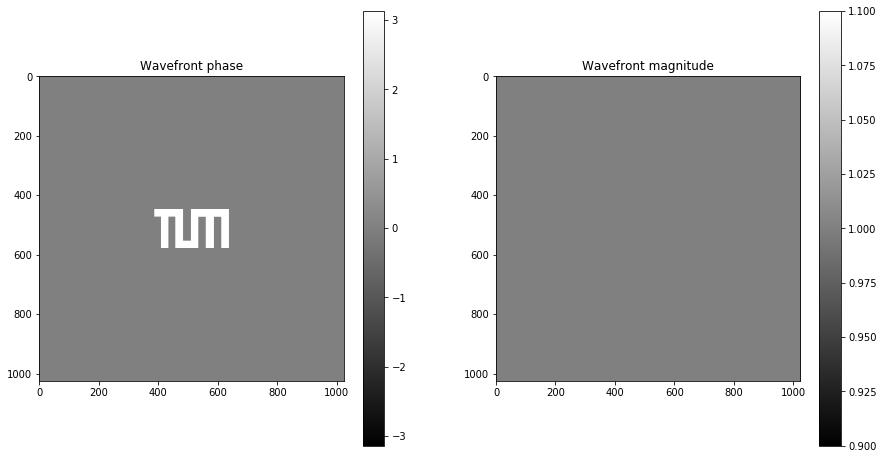

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.title('Wavefront phase')
plt.imshow(np.angle(w), cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.title('Wavefront magnitude')
plt.imshow(np.abs(w), cmap='gray', vmin=.9, vmax=1.1)
plt.colorbar()

## 1b) Generate the Fresnel kernel

Generate grids for Fourier-domain kernel:

In [9]:
u = 2. * np.pi * np.fft.fftfreq(img.shape[1], psize)
v = 2. * np.pi * np.fft.fftfreq(img.shape[0], psize)

uu, vv = np.meshgrid(u, v, indexing='xy')

Calculate the wave number:

In [10]:
k = 2 * np.pi / wlen

Generate the kernel:

In [11]:
kernel = np.exp(-.5j * prop_dist / k * (uu**2 + vv**2))

## 1c) Calculate and examine the near-field diffraction pattern:

Calculate the propagated wave array:

In [12]:
out = np.fft.ifft2(np.fft.fft2(w) * kernel)

Plot the phase of the kernel:

(We use the periodic colormap `hsv` to have a continuous transition from $-\pi$ to $\pi$.)

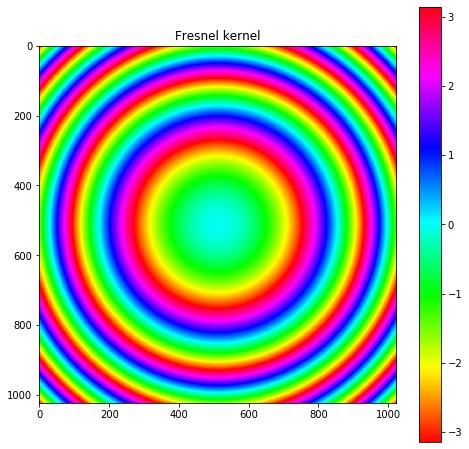

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(np.fft.fftshift(np.angle(kernel)), cmap='hsv', interpolation='none')
plt.title('Fresnel kernel')
plt.colorbar()

Calculate the intensity from the propagated wave array:

In [14]:
I = np.abs(out)**2

Plot the propagated intensity (zoomed in to the center of the image):

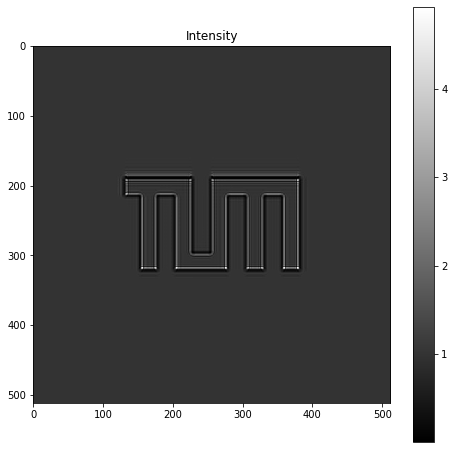

In [15]:
plt.figure(figsize=(8,8))
crop = 256
plt.imshow(I[crop:-crop,crop:-crop], cmap='gray')
plt.title('Intensity')
plt.colorbar()

# Exercise 2: Fraunhofer propagation

Generate a "speckle pattern" from an atmospheric phase screen using Fraunhofer propagation.

We would like to model the setup shown below:

![title](geometry_fraunhofer.png)

Atmospheric disturbances introduce random phase variations to (initially undisturbed) wavefronts.
These are then detected in an optical instrument consisting of an aperture and a converging lens.
We would like to simulate the resultant image in the focal plane of the lens.

Define relevant parameters:

In [16]:
N = 1024  # Square dimension of phase screen
radius = 128  # Radius of the circular aperture in pixels

Generate an NxN array of zeros for the aperture:

In [22]:
aperture = np.zeros((N,N))
aperture.shape

(1024, 1024)

Fill `aperture` with the transmission function of a circular aperture of radius `radius`:

Transmission should be `1` within the aperture, and `0` outside.

Functions of interest include: `np.meshgrid`, `np.linspace`, `np.arange` ...

Hint: In cartesian coordinates $(x,y)$, a circle of radius $r$
centered around the origin $(x_0, y_0)$ is given by: $(x-x_0)^2 + (y-y_0)^2 = r^2$.

In [24]:
x = np.linspace(-N/2, N/2, N)
y = np.linspace(-N/2, N/2, N)
xx, yy = np.meshgrid(y, x)
circle = xx**2 + yy**2

aperture = circle < radius**2 

Plot your aperture function:

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

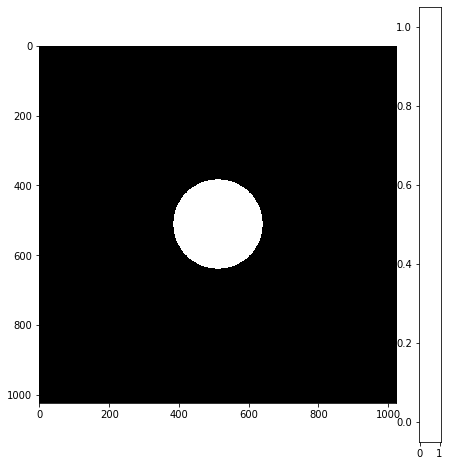

In [25]:
plt.figure(figsize=(8,8))
plt.imshow(aperture, cmap='gray')
plt.colorbar()

Load in the wavefront phase screen and plot it:

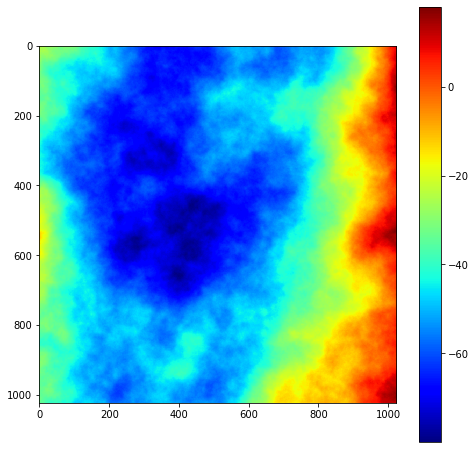

In [26]:
screen = np.loadtxt('wavefront.txt')
plt.figure(figsize=(8,8))
plt.imshow(screen, cmap='jet', interpolation='none')
plt.colorbar()

Propagate the phase screen from the aperture to the focal plane using Fraunhofer propagation.

Hints:

* `aperture` is the magnitude, and `screen` is the phase.
* Fraunhofer propagation: Wave at focal plane is FT of wave at aperture plane
* You may need to use an `np.fft.fftshift` here!
* Intensity is the absolute value of field at the focal plane squared

In [27]:
speckle = np.abs(np.fft.fftshift(np.fft.fft2(aperture *np.exp(1j * screen))))**2

Show the far-field propagation image.
Near the center of the image, speckle patterns should be visible.

Crop the center of the image to see more details!

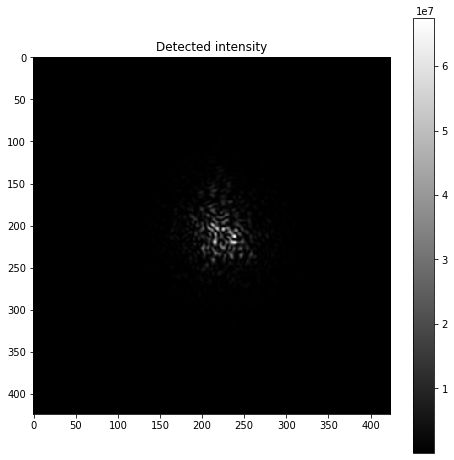

In [28]:
plt.figure(figsize=(8,8))
plt.title('Detected intensity')
crop = 300
plt.imshow(speckle[crop:-crop, crop:-crop], cmap='gray')
plt.colorbar()